# Learning Useful SPs from Wikipedia Text

We can a stream of articles from wikipedia as a corpus for learning useful semantic pointers that capture various relationships between words. First, we'll set up the corpus, build a vocabulary of words to model, and check the size of this vocabulary:

In [1]:
import os
from embeddings import RandomIndexing
from corpora import Wikipedia

wiki = Wikipedia(path=os.getcwd()+'/wikipedia/', article_limit=100)
wiki.load_vocab('tutorial_words')

print('Vocab size: ', len(wiki.vocab))

Vocab size:  14924


### Context Encoding

Now, we can build a basic random indexing model to encode the word co-occurence patterns in these articles into a set of high-dimensional vectors. This method is related to well-known algorithms such as LSA, Word2Vec (i.e. CBOW + skip-gram encoding), and GloVe. One benefit of random indexing is that it is easy to parallelize, and hence efficient to run on large corpora:

In [2]:
dim = 512

model = RandomIndexing(wiki)
model.train(dim=dim, wordlist=wiki.vocab, flags=['context'], batchsize=100)
print('Computation time: ', model.runtime)

Computation time:  14.567392110824585


We can find the nearest neighbors to any word in the resulting 'semantic space' with just a few lines of code. Note that with this small amount of training data, the results will be specific to the topics of the wikipedia articles that have been chosen:

In [3]:
word_list = ['brain','movie','philosophy','political','oil','president']

for word in word_list:
    print('Nearest neighbors to "%s":' % word)
    model.get_nearest(word)
    print('')

Nearest neighbors to "brain":
brain 1.0
autism 0.553374610268
disorders 0.51541903109
mutations 0.493268692049
hypothesizes 0.462079199997

Nearest neighbors to "movie":
movie 1.0
conferred 0.447116243379
editing 0.380842887899
studios 0.373074281558
oscars 0.359450583492

Nearest neighbors to "philosophy":
philosophy 1.0
metaphysics 0.601110633783
logic 0.506216248486
schopenhauers 0.505491980124
analytics 0.498200368514

Nearest neighbors to "political":
political 1.0
social 0.555393589326
government 0.542452295424
economic 0.540170180303
among 0.537868278942

Nearest neighbors to "oil":
oil 1.0
crude 0.784156806341
reserves 0.700447443373
petroleum 0.679685259287
sands 0.674417607168

Nearest neighbors to "president":
president 1.0
government 0.612171292261
presidential 0.593313798363
lincoln 0.572562973226
appointed 0.563638220492



### Order Encoding

To make the model a bit more interesting, we can encode positional information about the words that tend to occur around each target word in our voabulary. This amounts to adding information about ngrams in the corpus to each semantic vector. Computation is a bit more costly in this case, due to the need to compute several circular convolutions per word occurence. Again, though, this computation can be parallelized, so it's not too bad to implement.

In [4]:
model.train(dim=dim, wordlist=wiki.vocab, flags=['order'], batchsize=100)
print('Computation time: ', model.runtime)

Computation time:  48.422404050827026


The resulting vectors can be queried for likely words occuring in positions to left and right of a target word. We can also find words that tend to occur in the same 'order contexts' as a target word:

In [5]:
word_list = ['king','abraham','of','academy','argued','give','each','abraham']

for word in word_list:
    print('Likely words next to "%s":' % word)
    model.get_order_completions(word, position=1)
    print('')

Likely words next to "king":
of 0.463785132911
unfertilised 0.192109651335
bidirectional 0.189980010534
theth 0.175625333671
xyz 0.173383653778

Likely words next to "abraham":
lincoln 0.711818188677
became 0.237716434612
society 0.198266397898
anatomy 0.157829729809
examiner 0.15091506397

Likely words next to "of":
the 0.582065557051
starspangled 0.185095293149
achilleion 0.159463792642
binarycoded 0.158944516011
reduce 0.157181879589

Likely words next to "academy":
awards 0.387322932264
of 0.194605747429
sulfide 0.165924804099
award 0.156611761839
trenches 0.150292665498

Likely words next to "argued":
that 0.820680642127
in 0.169835448232
essays 0.155389006086
potentials 0.149883098399
starring 0.148145982758

Likely words next to "give":
region 0.181145661765
enlarged 0.170487700433
reptiles 0.156575992582
defendants 0.155729726652
aplu 0.150974888382

Likely words next to "each":
other 0.426771706441
of 0.22248349309
year 0.179500027358
select 0.159634083345
hitchcock 0.15946639

There's a more accurate way to find preceding and subsequent words - we simply look for order vectors that tend to encode the target word in particular positions.

In [51]:
phrase_list = [ 'promoted __ rights', 'lincoln promoted __ rights', 'president __', 
               ' __ civil war', 'aristotle held more __ theories']

for phrase in phrase_list:
    print('Phrase completion for %s' % phrase)
    model.get_resonants(phrase)
    print('')

Phrase completion for promoted __ rights
womens 0.335504796435
voting 0.276998170505
exploitation 0.20581297091
abortion 0.192287061047
implied 0.177585511354

Phrase completion for lincoln promoted __ rights
voting 0.282712086313
womens 0.250675486724
desperate 0.249931406133
supervised 0.243289690845
vetoed 0.220900804418

Phrase completion for president __
barack 0.463492333227
abdelaziz 0.446733530829
nixons 0.367586582397
sali 0.36727889193
stephens 0.358848863233

Phrase completion for  __ civil war
horrific 0.402918140167
devastating 0.316063357479
redefine 0.29038489282
condemning 0.245202850264
aversion 0.243374857738

Phrase completion for aristotle held more __ theories
accurate 0.384105012091
efficient 0.2940042558
than 0.288270736664
recently 0.281804625461
complex 0.275310813644



### Syntax Encoding

It is possible to extend the methods used for encoding order information to encode information about the syntactic structure of the sentences are word typically occurs in. We'll use dependency structures to model this information, primarily because they are simpler than constituency structures and thus easier to encode in vectors with a limited capacity for storing structured information (all the usual facts about HRR capacity apply here). Instead of encoding words to the left or right of a target word, we'll encode words that occur as parents or children of a target word in a dependency tree.

In [7]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "http://taweb.aichi-u.ac.jp/tmgross/pix/PSG-DG.png")

The resulting vectors can be used to query a target word for words that are commonly linked to it by a given dependency relation. 

In [8]:
model.train(dim=dim, wordlist=wiki.vocab, flags=['syntax'], batchsize=100)
print('Computation time: ', model.runtime)

Computation time:  24.677356958389282


In [9]:
word_list = ['notice','give','emphasized','presented','invited','appeals']

for word in word_list:
    print('Common nsubj for "%s":' % word)
    model.get_verb_completions(word, 'nsubj')
    print('')

for word in word_list:
    print('Common dobj for "%s":' % word)
    model.get_verb_completions(word, 'dobj')
    print('')

Common nsubj for "notice":
one 0.589612021551
parents 0.582759579619
foreshadowing 0.211782941796
polybius 0.169760571271
algeria 0.16773558719

Common nsubj for "give":
which 0.256778438528
he 0.230040590005
tokyo 0.174100964248
render 0.17376656367
amphibia 0.16410990298

Common nsubj for "emphasized":
lincoln 0.293102260193
historians 0.288281200487
douglas 0.281414743428
anthropology 0.273782094897
iatrochemistry 0.222829859519

Common nsubj for "presented":
aruba 0.40433219993
greene 0.337882812417
lincoln 0.29751471314
rand 0.230888999871
idealism 0.212200962809

Common nsubj for "invited":
government 0.298560261295
leaders 0.288570658655
king 0.288181845405
chaplin 0.273591999567
massoud 0.239090385475

Common nsubj for "appeals":
party 0.492989761677
who 0.456972782005
defendant 0.424644118102
begs 0.171405268043
regulations 0.166673620422

Common dobj for "notice":
signs 0.568059994654
colors 0.464936381058
simon 0.178684414446
altering 0.166419950221
protagonists 0.1575864604

In [10]:
for word in word_list:
    print('Likely counterparts to "%s":' % word)
    model.get_verb_neighbors(word)
    print('')

Likely counterparts to "notice":
notice 1.0
die 0.455148791944
grazed 0.43020797046
class 0.4130810465
touched 0.383206999232

Likely counterparts to "give":
give 1.0
gave 0.423932664686
giving 0.337555491341
fought 0.310825953652
seen 0.302428529317

Likely counterparts to "emphasized":
emphasized 1.0
declared 0.342246366259
scheduling 0.33390490284
insisted 0.319284666071
adhered 0.31215892745

Likely counterparts to "presented":
presented 1.0
promoted 0.321566741229
presided 0.276286264499
reviewed 0.276286264499
vetoed 0.269916462958

Likely counterparts to "invited":
invited 1.0
perish 0.310159958911
hired 0.303248016688
inviting 0.267100088287
impressed 0.264277330846

Likely counterparts to "appeals":
appeals 1.0
grabbing 0.506578181524
appealing 0.46777828796
blessed 0.46777828796
communicated 0.46777828796



# Using Learned SPs in a Nengo Model

When using the SPA system, we often specify vocabularies that contain various semantic pointers that the components in a SPA model then become aware of. Because we can specify the elements in these vocabularies directly, we can use the vectors we just learned from wikipedia to produce vocabularies that possess SPs with interesting semantic properties. This is a nice alterative to using the default, random SPs.

In [74]:
import nengo
import nengo.spa as spa

import matplotlib.pyplot as plt
%matplotlib inline

words = ['go','abraham','was','a','the','to','race','politician','agreement','also','test','walked','chase','related',
        'ants','alone','heidegger','light','water','disorders','resumed','refuse','anger','just','help','trade','court',
        'commonly','lincoln','moment','wine','hamlet','aardvark','differently','materials','occurring','surface',
        'phrase','car','dirt','at','trust','brain','physiology','house','martin','womens','voting','accurate']

context_vocab = spa.Vocabulary(dim)
order_vocab = spa.Vocabulary(dim)
syntax_vocab = spa.Vocabulary(dim)

for word in words:
    context_vocab.add(word.upper(), model.context_vectors[model.word_to_index[word], :])
    order_vocab.add(word.upper(), model.order_vectors[model.word_to_index[word], :])
    syntax_vocab.add(word.upper(), model.syntax_vectors[model.word_to_index[word], :])

As an initial illustration, we can build a simple SPA model that estimates how related two words are. This takes just a few lines of code to implement:

In [53]:
def first_word(t):
    return 'AARDVARK'

def second_word(t):
    return 'ANTS'
    
with spa.SPA() as simple_model:
    simple_model.word_1 = spa.State(dimensions=dim, vocab=context_vocab)
    simple_model.word_2 = spa.State(dimensions=dim, vocab=context_vocab)
    simple_model.relate = spa.Compare(dimensions=dim, vocab=context_vocab)
    
    nengo.Connection(simple_model.word_1.output, simple_model.relate.inputA)
    nengo.Connection(simple_model.word_2.output, simple_model.relate.inputB)
    
    simple_model.inputs = spa.Input(word_1=first_word, word_2=second_word)
    
    word_1_probe = nengo.Probe(simple_model.word_1.output, synapse=0.03)
    word_2_probe = nengo.Probe(simple_model.word_2.output, synapse=0.03)
    relate_probe = nengo.Probe(simple_model.relate.output, synapse=0.1)

sim = nengo.Simulator(simple_model)
sim.run(0.5)

Simulation finished in 0:00:39.                                                                                                                                                                             


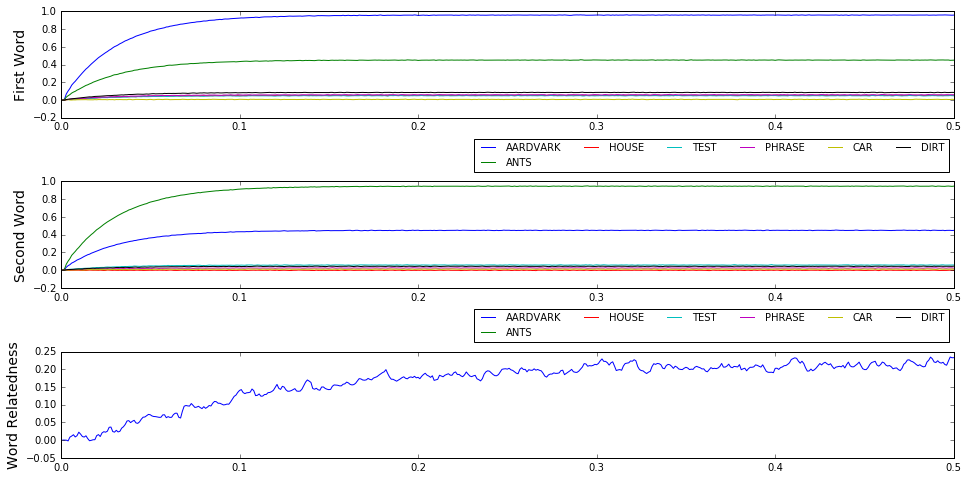

In [54]:
plotting_vocab = context_vocab.create_subset(['AARDVARK','ANTS','HOUSE','TEST','PHRASE','CAR','DIRT'])

fig = plt.figure(figsize=(16,8))
n = 3
p1 = fig.add_subplot(n,1,1)
p1.plot(sim.trange(), simple_model.similarity(sim.data, word_1_probe, vocab=plotting_vocab))
p1.legend(plotting_vocab.keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=6)
p1.set_ylabel('First Word', fontsize=14)

p2 = fig.add_subplot(n,1,2)
p2.plot(sim.trange(), simple_model.similarity(sim.data, word_2_probe, vocab=plotting_vocab))
p2.legend(plotting_vocab.keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=6)
p2.set_ylabel('Second Word', fontsize=14)

p3 = fig.add_subplot(n,1,3)
p3.plot(sim.trange(), sim.data[relate_probe])
p3.set_ylabel('Word Relatedness', fontsize=14)

fig.subplots_adjust(hspace=0.6)
plt.show()

We can check how well this nengo model is measuring the relatedness of these two terms by showing the true dot product of the underlying vectors:

In [55]:
model.get_nearest('aardvark')

aardvark 1.0
ants 0.472688524352
genus 0.423199238765
burrows 0.410394722223
termites 0.399273457999


For a slightly more complicated model, let's build a network that predicts the next word given some sequence of words. To do so, we'll match vectors that encode a sequence of n words to the vectors corresponding to the next word using an associative memory. 

In [75]:
order_vocab.add('TEST_PHRASE_1', model.get_vector_encoding('promoted __ rights'))
order_vocab.add('TEST_PHRASE_2', model.get_vector_encoding( 'lincoln promoted __ rights'))
order_vocab.add('TEST_PHRASE_3', model.get_vector_encoding('aristotle held more __ theories'))

uppercase_words = [w.upper() for w in words]

def built_phrase(t):
    if t < 0.2:
        return 'TEST_PHRASE_1'
    elif t < 0.35:
        return 'TEST_PHRASE_2'
    else:
        return 'TEST_PHRASE_3'
    
with spa.SPA() as ngram_model:
    ngram_model.ngram = spa.State(dimensions=dim, vocab=order_vocab)
    ngram_model.match = spa.AssociativeMemory(order_vocab, input_keys=uppercase_words, output_keys=uppercase_words,
                                              threshold=0.25)
    
    nengo.Connection(ngram_model.ngram.output, ngram_model.match.input)
    
    ngram_model.input = spa.Input(ngram=built_phrase)
    
    ngram_probe = nengo.Probe(ngram_model.ngram.output, synapse=0.03)
    match_probe = nengo.Probe(ngram_model.match.output, synapse=0.1)
    
sim = nengo.Simulator(ngram_model)
sim.run(0.5)

Simulation finished in 0:00:03.                                                                                                                                                                             


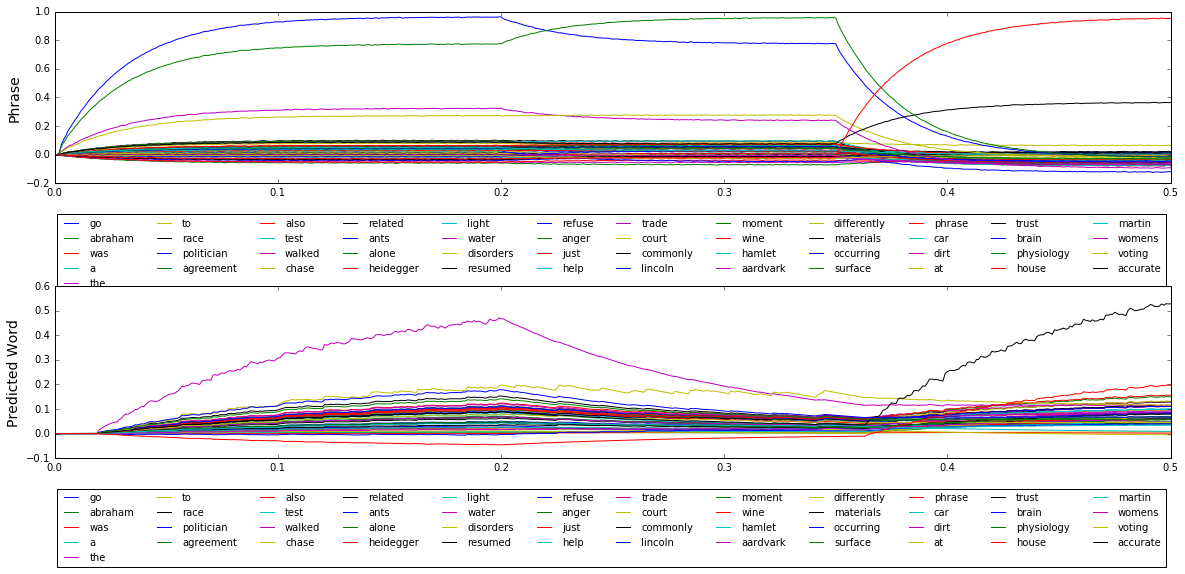

In [76]:
fig = plt.figure(figsize=(20,8))
p1 = fig.add_subplot(2,1,1)
p1.plot(sim.trange(), simple_model.similarity(sim.data, ngram_probe, vocab=order_vocab))
p1.legend(words, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=12)
p1.set_ylabel('Phrase', fontsize=14)

p2 = fig.add_subplot(2,1,2)
p2.plot(sim.trange(), simple_model.similarity(sim.data, match_probe, vocab=order_vocab))
p2.legend(words, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=12)
p2.set_ylabel('Predicted Word', fontsize=14)

fig.subplots_adjust(hspace=0.6)
plt.show()